[PMID: 31209404](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6726437/)

[SDY997](https://www.immport.org/shared/study/SDY997)

[Single Cell Protal: amp-phase-1 (t_SNE coordinates )](https://portals.broadinstitute.org/single_cell/study/amp-phase-1)

和RA那个数据集是一伙的

analyze kidney biopsies from **24 patients with LN** and **10 control samples**

2,736 leukocytes and 145 epithelial cells  这么少？？？

```shell
gzip -dc exprMatrixSleBroad.tsv.gz | head -n 10 | awk '{print $1,$2,$3}'

# gene K003_L1Q1_A03 K003_L1Q1_A05
# A1BG 0 0
# A1BG-AS1 0 0
# A1CF 2.64864345966836 0
```
`exprMatrixSleBroad.tsv.gz`不是count,唉。。。


In [1]:
import sys
from pathlib import Path
p_temp = str(Path("~/link/res_publish/").expanduser())
None if p_temp in sys.path else sys.path.append(p_temp)
del p_temp

In [2]:
from func import *
import utils as ut
from utils.general import *

sc = ut.sc.sc
pl = ut.pl

2024-09-06 20:20:10.249644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

# meta

In [6]:
p_sc = p_data_process.joinpath('SLE_SDY997','SDY997/ResultFile/RNA_sequencing_result')
df_meta = pd.read_csv(p_sc.joinpath('SDY997_EXP15176_celseq_meta_unfiltered.tsv.725703.gz'),
            sep='\t')
df_meta = df_meta.loc[df_meta['cell_name'].notna(),'cell_name,barcode,sample,type,disease'.split(',')]
df_meta = ut.df.reindex_with_unique_col(df_meta,'cell_name',drop=True)
df_meta = df_meta.join(pd.read_csv(p_sc.joinpath('cluster_per_cell.736296.txt'),index_col=0,sep='\t')).dropna()
ut.df.show(df_meta)

,barcode,sample,type,disease,cluster
K003_L1Q1_A05,AGTGCA,200-0608,Epithelial,Control,CE0
K003_L1Q1_A09,ACGTAC,200-0608,Epithelial,Control,CE0


(2838, 5)

# adata

In [ ]:
adata = pd.read_csv(p_sc.joinpath(
        'SDY997_EXP15176_celseq_matrix_ru10_molecules.tsv.725699.gz'),index_col=0,sep='\t').transpose()
display(adata.head(2))
adata = sc.AnnData(adata.fillna(0))
ut.sc.show(adata,1,0,1,0,1)

In [ ]:
display(adata.obs.index.isin(df_meta.index).sum()
,adata[adata.obs.index.isin(df_meta.index),:])

In [ ]:
display(adata)
adata = adata[adata.obs.index.isin(df_meta.index),:]
display(adata)

In [ ]:
adata.obs = adata.obs.loc[:,[]].join(df_meta)
display(adata,adata.obs.head(2),
    adata.obs.shape,adata.obs['subtype'].notna().sum())

In [ ]:
display(adata,adata.obs.head(2),
        adata.obs.shape,adata.obs['subtype'].notna().sum())
adata = adata[adata.obs['subtype'].notna()]
adata.obs['status'] = adata.obs['disease'].map({'SLE':'SLE','Control':'healthy'})
adata.obs['_batch'] = ut.df.apply_merge_field(adata.obs,'{disease}_{sample}')
adata.obs = adata.obs.rename(columns={
    'type':'pre_cell_type',
    'subtype':'pre_sub_cell_type_id'
})

with Block('map_cell_type_id',context = dict(p_out=Path('map_cell_type_id.json'))) as context:
    map_cell_type_id = {
        'CM0':'inflammatory CD16+ macrophages',
        'CM1':'Phagocytic CD16+ macrophages',
        'CM2':'Tissue-resident macrophages',
        'CM3':'cDCs',
        'CM4':'M2-link CD16+ macrophages',
        'CT0a':'Effector memory CD4+ T cells',
        'CT0b':'Central memory CD4+ T cells',
        'CT1':'CD56 dim CD16+ NK cells',
        'CT2':'CTLs',
        'CT3a':'Treg cells',
        'CT3b':'TFH-like cells',
        'CT4':'GZMK+ CD8+ Tcells',
        'CT5a':'Resident memory CD8+ Tcells',
        'CT5b':'CD56 bright CD16- NK cells',
        'CT6':'ISG-high CD4+ T cells',
        'CB0':'Activated B cells',
        'CB1':'Plasma cells/Plasmablasts',
        'CB2a':'Naive B cells',
        'CB2b':'pDCs',
        'CB3':'ISG-high B cells',
        'CD0':'Dividings cells',
        'CE0':'Epithelial cells',
    }
    context.p_out.write_text(json.dumps(map_cell_type_id))
    print('[out] {}'.format(context.p_out))

adata.obs['pre_sub_cell_type'] = adata.obs['pre_sub_cell_type_id'].map(lambda k:map_cell_type_id.setdefault(k,k))
adata.obs['cell_type'] = adata.obs['pre_sub_cell_type_id'].map(lambda k:{
    'CM0':'macrophages',
    'CM1':'macrophages',
    'CM2':'macrophages',
    'CM3':'DCs',
    'CM4':'macrophages',
    'CT0a':'T cells',
    'CT0b':'T cells',
    'CT1':'NK cells',
    'CT2':'T cells',
    'CT3a':'T cells',
    'CT3b':'T cells',
    'CT4':'T cells',
    'CT5a':'T cells',
    'CT5b':'NK cells',
    'CT6':'T cells',
    'CB0':'B cells',
    'CB1':'B cells',
    'CB2a':'B cells',
    'CB2b':'DCs',
    'CB3':'B cells',
    'CD0':'Dividings cells',
    'CE0':'Epithelial cells',
}.setdefault(k,k))
display(adata,adata.obs.head(2))

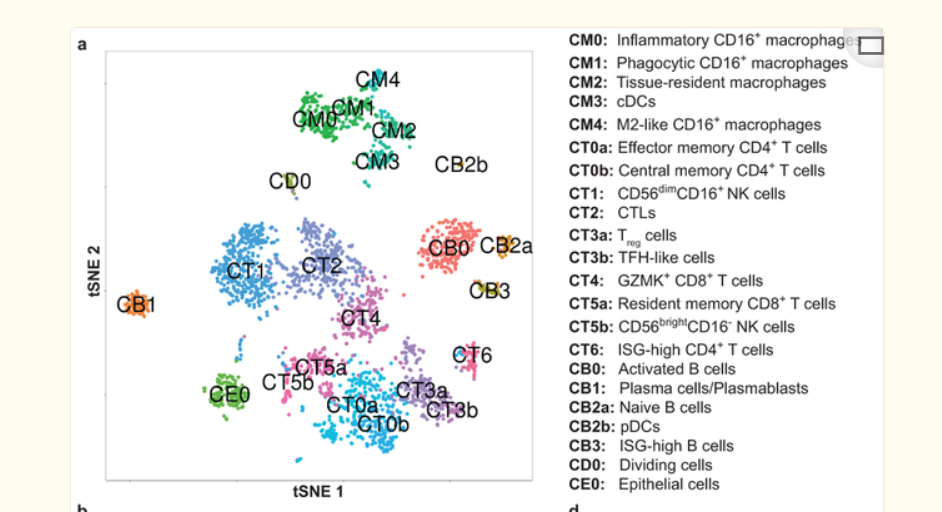

In [ ]:
with Block('tsne'):
    data = adata.obs.copy().sort_values('pre_sub_cell_type_id')
    df_tsne = pd.DataFrame(json.loads(Path('t_SNE_coordinates_SLE-Broad.json').read_text())['data']).rename(
            columns={'annotations':'pre_sub_cell_type_id','cells':'cell_name','x':'tSNE1','y':'tSNE2'}
        ).pipe(ut.df.reindex_with_unique_col,'cell_name',True).sort_values('pre_sub_cell_type_id')
    assert (data['pre_sub_cell_type_id'].to_numpy() == df_tsne['pre_sub_cell_type_id'].to_numpy()).all()
    data['tSNE1'] = df_tsne['tSNE1'].to_numpy()
    data['tSNE2'] = df_tsne['tSNE2'].to_numpy()
    adata.obs = adata.obs.loc[:,[]].join(data)
    del data,df_tsne

In [ ]:
ut.sc.show(adata,1,0,1)
display(adata.obs['cell_type'].value_counts(),
        # adata.obs['pre_sub_cell_type'].value_counts(),
        adata.obs['pre_sub_cell_type_id'].value_counts())

In [ ]:
lims = None
adata = ut.sc.load_obsm_UMAP(adata,'tSNE1,tSNE2'.split(','))
with Block("umap",context=dict(adata = adata,key = 'pre_sub_cell_type_id',cmap={})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,3)
    ut.sc.pl.umap(context.adata,context.key,size=1,cmap=context.cmap,ax=axs[0])
    lims = (axs[0].get_xlim(),axs[0].get_ylim())
    for ax,keys in zip(axs[1:],np.array_split(list(context.cmap.keys()),2)):
        pl.cmap.show(subset_dict(context.cmap,keys),ax=ax,text_x=.02)
    display(fig)
    del fig,axs
print(lims)

In [ ]:
adata.obs = adata.obs.loc[:,'_batch,status,disease,sample,cell_type,pre_sub_cell_type,pre_cell_type,pre_sub_cell_type_id,tSNE1,tSNE2'.split(',')]
display(adata,adata.obs.head(2),adata.obs['status'].value_counts())
with Block('save as mtx',context=dict(adata=adata,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997'))) as context:
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)

# imm

In [ ]:
adata_imm = ut.sc.subset_adata(adata,'cell_type','macrophages,DCs,NK cells,T cells,B cells'.split(','))\
    .copy()
display(adata_imm.obs['cell_type'].value_counts(),
        adata_imm.obs['pre_sub_cell_type'].value_counts())

adata_imm.obs['cell_type'] = adata_imm.obs['cell_type'].map(lambda k:{
    'B cells':'B cell',
    'T cells':'T cell',
    'NK cells':'natural killer cell',
    'macrophages':'macrophage'
}.setdefault(k,k))
display(adata_imm.obs['cell_type'].value_counts())

In [ ]:
with Block('save as mtx',context=dict(adata=adata_imm,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)

## T cell

In [ ]:
adata_T = ut.sc.subset_adata(adata_imm,'cell_type','T cell').copy()
adata_T = ut.sc.load_obsm_UMAP(adata_T,'tSNE1,tSNE2'.split(','))
adata_T.obs['sub_cell_type'] = adata_T.obs['pre_sub_cell_type']
ut.sc.show(adata_T)
with Block("umap",context=dict(adata = adata_T,key = 'pre_sub_cell_type_id',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,cmap=context.cmap,ax=axs[0],size=2)
    axs[0].set_xlim(*lims[0]),axs[0].set_ylim(*lims[1])
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs
with Block('save as mtx',context=dict(adata=adata_T,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_T'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)
del adata_T

In [ ]:
adata_T = ut.sc.subset_adata(adata_imm,'cell_type','T cell')
adata_T.obs = adata_T.obs.loc[:,
    '_batch,status,disease,sample,pre_sub_cell_type,pre_sub_cell_type_id'.split(',')].join(
        pd.read_csv('obs_Seurat_T.csv',index_col=0)
    )
ut.df.show(adata_T.obs)
display(adata_T.obs['cell_type'].value_counts())

adata_T = ut.sc.load_obsm_UMAP(adata_T,'UMAP1,UMAP2'.split(','))
with Block("umap",context=dict(adata = adata_T,key = 'sub_cell_type',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,cmap=context.cmap,ax=axs[0],size=2)
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs
with Block('save as mtx',context=dict(adata=adata_T,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_T2'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)

## B cell

In [ ]:
adata_B = ut.sc.subset_adata(adata_imm,'cell_type','B cell').copy()
ut.sc.show(adata_B)
adata_B.obs['sub_cell_type'] = adata_B.obs['pre_sub_cell_type']
adata_B = ut.sc.load_obsm_UMAP(adata_B,'tSNE1,tSNE2'.split(','))
with Block("umap",context=dict(adata = adata_B,key = 'pre_sub_cell_type_id',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,size=1,cmap=context.cmap,ax=axs[0])
    axs[0].set_xlim(*lims[0]),axs[0].set_ylim(*lims[1])
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs

with Block('save as mtx',context=dict(adata=adata_B,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_B'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)
del adata_B

In [ ]:
adata_B = ut.sc.subset_adata(adata_imm,'cell_type','B cell').copy()
adata_B.obs = adata_B.obs.loc[:,
    '_batch,status,disease,sample,pre_sub_cell_type,pre_sub_cell_type_id'.split(',')].join(
        pd.read_csv('obs_Seurat_B.csv',index_col=0)
    )
display(adata_B.obs.head(2),adata_B.obs['cell_type'].value_counts())
adata_B = ut.sc.subset_adata(adata_B,'cell_type','B cell,plasma cell'.split(',')).copy()
display(adata_B.obs.head(2),adata_B.obs['cell_type'].value_counts())
adata_B = ut.sc.load_obsm_UMAP(adata_B,'UMAP1,UMAP2'.split(','))

with Block("umap",context=dict(adata = adata_B,key = 'sub_cell_type',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,cmap=context.cmap,ax=axs[0],size=2)
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs
    
with Block('save as mtx',context=dict(adata=adata_B,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_B2'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)
del adata_B

## macrophage

In [ ]:
adata_mar = ut.sc.subset_adata(adata_imm,'cell_type','macrophage').copy()
adata_mar.obs['sub_cell_type'] = adata_mar.obs['pre_sub_cell_type']
ut.sc.show(adata_mar)
adata_mar = ut.sc.load_obsm_UMAP(adata_mar,'tSNE1,tSNE2'.split(','))
with Block("umap",context=dict(adata = adata_mar,key = 'pre_sub_cell_type_id',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,size=1,cmap=context.cmap,ax=axs[0])
    axs[0].set_xlim(*lims[0]),axs[0].set_ylim(*lims[1])
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs

with Block('save as mtx',context=dict(adata=adata_mar,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_mar'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)
del adata_mar

## NK

In [ ]:
adata_nk = ut.sc.subset_adata(adata_imm,'cell_type','natural killer cell').copy()
adata_nk.obs['sub_cell_type'] = adata_nk.obs['pre_sub_cell_type']
ut.sc.show(adata_nk)
adata_nk = ut.sc.load_obsm_UMAP(adata_nk,'tSNE1,tSNE2'.split(','))
with Block("umap",context=dict(adata = adata_nk,key = 'pre_sub_cell_type_id',cmap = {})) as context:
    context.cmap.update(pl.cmap.get(context.adata.obs[context.key]))
    fig,axs = pl.figure.subplots_get_fig_axs(1,2)
    ut.sc.pl.umap(context.adata,context.key,size=1,cmap=context.cmap,ax=axs[0])
    axs[0].set_xlim(*lims[0]),axs[0].set_ylim(*lims[1])
    pl.cmap.show(context.cmap,ax=axs[1],text_x=.02)
    display(fig)
    del fig,axs

with Block('save as mtx',context=dict(adata=adata_nk,
    p_out = p_cache.joinpath('disease','SLE_h_SDY997_imm_NK'))) as context:
    
    if context.p_out.exists():
        print('[exists] {}\n\t{}'.format(context.p_out.name,context.p_out.parent))
    else:
        h5ad_to_mtx(context.adata,context.p_out)
del adata_nk

In [ ]:
del adata,adata_imm

# 标准流程

聚类挺不错的

In [ ]:
plt.close('all')

In [ ]:
adata = load_adata(p_cache.joinpath('disease','SLE_h_SDY997'))
display(adata,adata.obs.head(2),
        adata.obs.shape,adata.obs['pre_sub_cell_type_id'].notna().sum())
sc.pp.normalize_total(adata)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

sc.pp.neighbors(adata)
sc.tl.umap(adata)
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata)
sc.pl.umap(adata, color=["leiden"])

In [ ]:
sc.pl.umap(adata, color='sample,leiden,pre_cell_type,pre_sub_cell_type_id'.split(','),ncols=2)